In [20]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Imports

# third party
import jax
import jax.numpy as jnp
from jax._src.config import config
import matplotlib.pyplot as plt 
config.update("jax_enable_x64", True) #SHOULDN'T NEED THIS ANYMORE -- but just for safety
plt.style.use('/Users/juan/phd/matplotlib/jdefault.mplstyle')
from astropy.stats import histogram
#need to get rid of
import numpy as np
# project
from dynamicAll import models,sampler
from scipy.stats import binned_statistic

## Isochrone

In [5]:
model_params = {
    'M' : 1e9,
    'b': 0.5
}
model = models.Isochrone(**model_params)

In [6]:
nwalkers =323 
r_temp = np.logspace(-3,1,nwalkers)
# print(r_temp.shape)
v_temp = model.v_circ(r_temp)

x,y,z = model.spherical_to_cartesian(r_temp)
vx,vy,vz = model.spherical_to_cartesian(v_temp) 

In [7]:
ndim = 6
p0 = np.array([x,y,z,vx,vy,vz]).reshape(nwalkers,ndim)

In [8]:
G = 4.300917270036279e-06
print(-G*model_params['M']/model_params['b'])

-8601.83454007256


In [9]:
def df(w):
    x = w[:3]
    v = w[3:]
    r = np.linalg.norm(x)
    print(r)
    E = model.potential(r) + 0.5*np.dot(v,v)
    print(E)
    return model.logDF(E)

In [10]:
df(p0[0])

0.0016111513175006073
-4300.906105076206


Array(4.15778094, dtype=float64)

## Use general sampler that samples from $\vec{w}$ all at once

In [14]:
test_samples = model.sample_w(N=10_000)

100%|██████████| 10000/10000 [01:25<00:00, 117.09it/s]


This will generallly take longer than the conditional sampling, part of that is that by default, it will return 32 chains of N samples -- that can be changed by passing the nwalkers argument to sample_w.

Below we compare the results of the two methods by looking at the predicted velocity dispersion profile.

In neither case does the sampler know about the velocity dispersion so it seems like a good test of the samplers. 
You should also look at the mean acceptance fraction and mean autocorrelation time to make sure the sampler is working "well."

In [12]:
x = test_samples[:,0]
y = test_samples[:,1]
z = test_samples[:,2]
vx = test_samples[:,3]
vy = test_samples[:,4]
vz = test_samples[:,5]
r = np.sqrt(x**2 + y**2 + z**2)
vr = (x*vx + y*vy + z*vz)/r

In [13]:
q = np.random.randint(0,320_000,10_000)
N,bin_edges = histogram(r[q],bins='blocks')
r_center = (bin_edges[1:] + bin_edges[:-1])/2
meanv2,_,bin_numbers = binned_statistic(r[q],vr[q],'mean',bins=bin_edges)
mu2,_,bin_numbers    = binned_statistic(r[q],vr[q]**2,'mean',bins=bin_edges)
meanv2_tot,_,bin_numbers = binned_statistic(r,vr,'mean',bins=bin_edges)
mu2_tot,_,bin_numbers    = binned_statistic(r,vr**2,'mean',bins=bin_edges)

IndexError: index 56909 is out of bounds for axis 0 with size 32000

In [ ]:
fig,ax = plt.subplots(1,2)

/var/folders/fs/60cg8qcd6gj8mwglqf70fhm40000gn/T/ipykernel_76701/1330375967.py:3: RuntimeWarning: invalid value encountered in sqrt
  ax.step(r_center,np.sqrt(mu2 - meanv2**2),


[None,
 Text(0.5, 0, 'r [kpc]'),
 Text(0, 0.5, '$\\sigma_r(r)$ [km/s]'),
 (0.0, 1.0)]

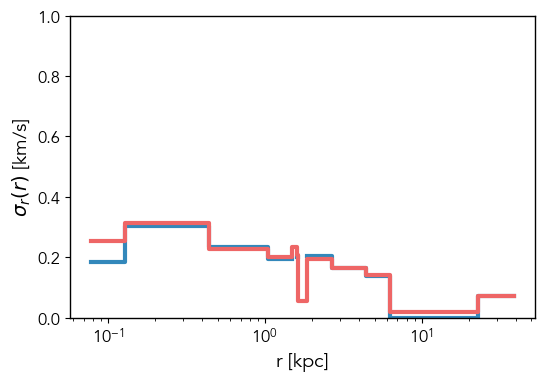

In [232]:
fig,ax = plt.subplots()

ax.step(r_center,np.sqrt(mu2 - meanv2**2),
        where = 'mid',
        label = 'sampled with emcee'
        )
ax.step(r_center,np.sqrt(mu2_tot - meanv2_tot**2),
        where = 'mid',
        label = 'sampled with emcee'
        )

ax.set(
    xscale='log',
    xlabel = 'r [kpc]',
    ylabel =r'$\sigma_r(r)$ [km/s]',
    ylim = (0,1),
)
# ax.plot(r_center,np.sqrt(model.dispersion(r_center)))
# ax.legend()

## compare velocity dispersions

It seems like we got a good match between the two methods.
there will always be some differences due to counting, and unlucky rng draws, but the two methods should be consistent.
The emcee sampler should better fit the true curve since its using n_chains*n_steps draws so it'll be more stable than the conditional sampler. 

However if we sample from the samples -- which we can do with just a by drawing uniformly from the flat-chain, we can get smaller subsamples
Drawing randomly from these is a quicker way to generate smaller sub-samples

## Hernquist 

In [15]:
model_params = {
    'M' : 1e5,
    'a': 0.5
}
model = models.Hernquist(**model_params)

In [16]:
samples = model.sample_w(N=10_000)

100%|██████████| 10000/10000 [01:00<00:00, 164.87it/s]


In [17]:
x = samples[:,0]
y = samples[:,1]
z = samples[:,2]
vx = samples[:,3]
vy = samples[:,4]
vz = samples[:,5]
r = np.sqrt(x**2 + y**2 + z**2)
vr = (x*vx + y*vy + z*vz)/r

In [24]:
# q = np.random.randint(0,320_000,10_000)
q = np.random.choice(320_000,10_000)  # Is this the best way to do this??
N,bin_edges = histogram(r[q],bins='blocks')
r_center = (bin_edges[1:] + bin_edges[:-1])/2
meanv2,_,bin_numbers = binned_statistic(r[q],vr[q],'mean',bins=bin_edges)
mu2,_,bin_numbers    = binned_statistic(r[q],vr[q]**2,'mean',bins=bin_edges)
meanv2_tot,_,bin_numbers = binned_statistic(r,vr,'mean',bins=bin_edges)
mu2_tot,_,bin_numbers    = binned_statistic(r,vr**2,'mean',bins=bin_edges)

[None, (0.0, 1.0), Text(0.5, 0, 'r [kpc]'), Text(0, 0.5, 'pdf(r)')]

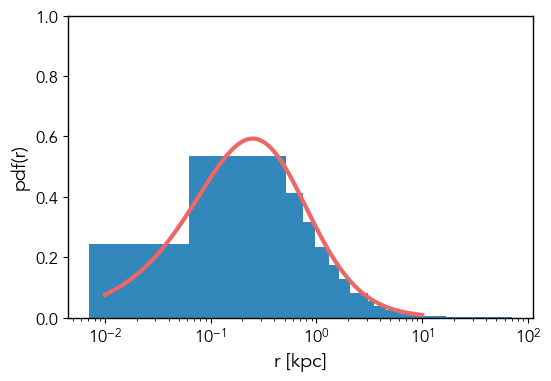

In [40]:
r_temp = np.logspace(-2,1,100)
fig,ax = plt.subplots()
ax.hist(r,bins=bin_edges,density=True)
ax.plot(r_temp,model.pdf_r(r_temp))
ax.set(
    xscale='log',
    ylim=[0,1],
    xlabel = 'r [kpc]',
    ylabel =r'pdf(r)'
)

/var/folders/fs/60cg8qcd6gj8mwglqf70fhm40000gn/T/ipykernel_76143/4053917976.py:3: RuntimeWarning: invalid value encountered in sqrt
  ax.step(r_center,np.sqrt(mu2 - meanv2**2),


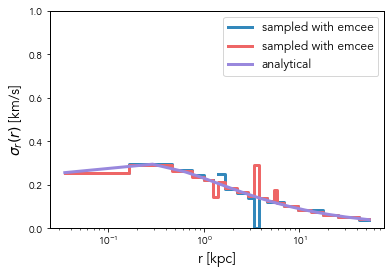

In [27]:
fig,ax = plt.subplots()

ax.step(r_center,np.sqrt(mu2 - meanv2**2),
        where = 'mid',
        label = 'sampled with emcee'
        )
ax.step(r_center,np.sqrt(mu2_tot - meanv2_tot**2),
        where = 'mid',
        label = 'sampled with emcee'
        )

ax.set(
    xscale='log',
    xlabel = 'r [kpc]',
    ylabel =r'$\sigma_r(r)$ [km/s]',
    ylim = (0,1),
)
ax.plot(r_center,np.sqrt(model.dispersion(r_center)),label='analytical')
ax.legend()

In [52]:
import astropy.units as u
# from astropy.units import imperial
# imperial.enable()
distance = 6400*u.km

In [59]:
vel = 100 * u.km/u.day

In [60]:
t = distance/vel
print(t)

64.0 d
